In [1]:
# ----------------------------------------------------
# 1. SETUP AND DATA LOAD
# ----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Load the data downloaded by the R script
DATA_PATH = "/Users/tommyrose/Desktop/CAP4773_Ass1/downloaded_nfl_data.csv"
df = pd.read_csv(DATA_PATH)

# Display initial info (Exercise 1)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244680 entries, 0 to 244679
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   game_id          244680 non-null  object 
 1   play_id          244680 non-null  int64  
 2   down             244680 non-null  int64  
 3   ydstogo          244680 non-null  int64  
 4   yardline_100     244680 non-null  int64  
 5   shotgun          244680 non-null  int64  
 6   no_huddle        244680 non-null  int64  
 7   rush_attempt     244349 non-null  float64
 8   pass_attempt     244349 non-null  float64
 9   first_down_rush  244349 non-null  float64
 10  first_down_pass  244349 non-null  float64
 11  touchdown        244349 non-null  float64
 12  qb_hit           244349 non-null  float64
 13  fumble_lost      244349 non-null  float64
 14  interception     244349 non-null  float64
dtypes: float64(8), int64(6), object(1)
memory usage: 28.0+ MB
None
           game_id  pl

In [2]:
# ----------------------------------------------------
# 2. DATA PREPROCESSING AND FEATURE ENGINEERING
# ----------------------------------------------------

# Define the Target Variable (Y): Play Success (1 = First Down or TD, 0 = Failure)
# A play is successful if it results in a first down OR a touchdown.
df['Successful_Play'] = (df['first_down_rush'].fillna(0) == 1) | \
                         (df['first_down_pass'].fillna(0) == 1) | \
                         (df['touchdown'].fillna(0) == 1)
df['Successful_Play'] = df['Successful_Play'].astype(int)

# Select relevant features (X) and Target (Y)
FEATURES = ['down', 'ydstogo', 'yardline_100', 'shotgun', 'no_huddle']
TARGET = 'Successful_Play'

df_model = df[FEATURES + [TARGET]].dropna()

X = df_model[FEATURES]
y = df_model[TARGET]

# Split data chronologically or randomly (Exercise 2, 7)
# Use stratification to maintain target balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define Preprocessing Pipeline (Scale continuous, One-Hot categorical) (Exercise 2, 7)
numerical_features = ['ydstogo', 'yardline_100']
categorical_features = ['down', 'shotgun', 'no_huddle']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)


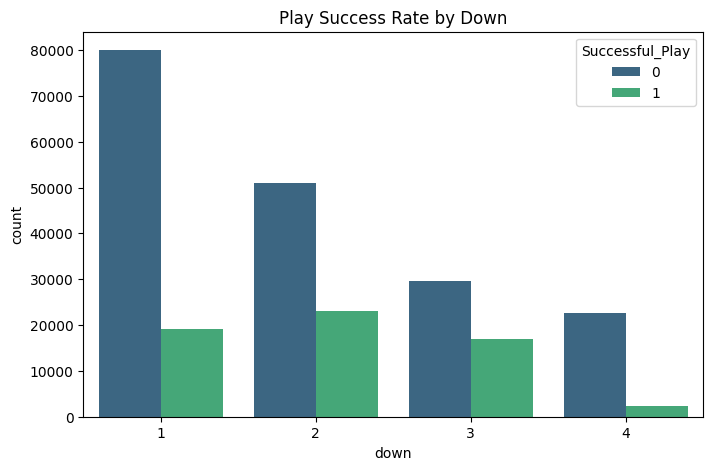

,down,ydstogo,yardline_100,Successful_Play
down,1.000000,-0.248641,-0.053922,0.030988
ydstogo,-0.248641,1.000000,0.228897,-0.263480
yardline_100,-0.053922,0.228897,1.000000,-0.032773
Successful_Play,0.030988,-0.263480,-0.032773,1.000000


In [3]:
# ----------------------------------------------------
# 3. EXPLORATION AND VISUALIZATION (EDA) (Exercise 3, 5)
# ----------------------------------------------------

# Example EDA: Distribution of Down
plt.figure(figsize=(8, 5))
sns.countplot(x='down', hue='Successful_Play', data=df_model, palette='viridis')
plt.title('Play Success Rate by Down')
plt.show()

# Example EDA: Correlation Matrix (Exercise 5, 6)
# Temporarily prepare data for correlation visualization
temp_corr = df_model[['down', 'ydstogo', 'yardline_100', 'Successful_Play']].copy()
temp_corr.corr().style.background_gradient(cmap='coolwarm')


In [4]:
# ----------------------------------------------------
# 4. MODELING (LOGISTIC REGRESSION) (Exercise 2, 7)
# ----------------------------------------------------

# Create the modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000))
])

# Train the model
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]


Model Accuracy: 0.7630
ROC AUC: 0.7049


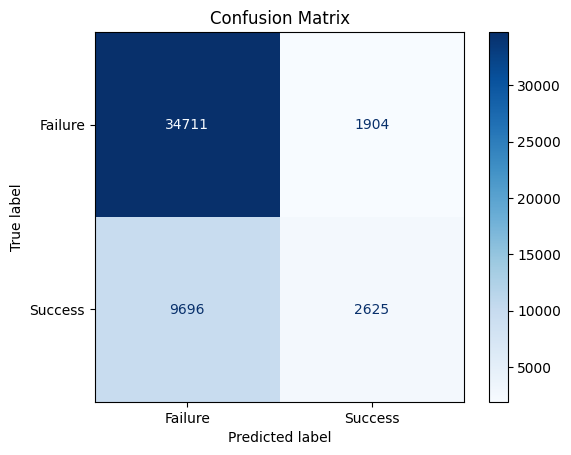

In [5]:
# ----------------------------------------------------
# 5. EVALUATION (Exercise 2, 7, 8)
# ----------------------------------------------------

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Model Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Visualize Confusion Matrix (Exercise 7)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failure', 'Success'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

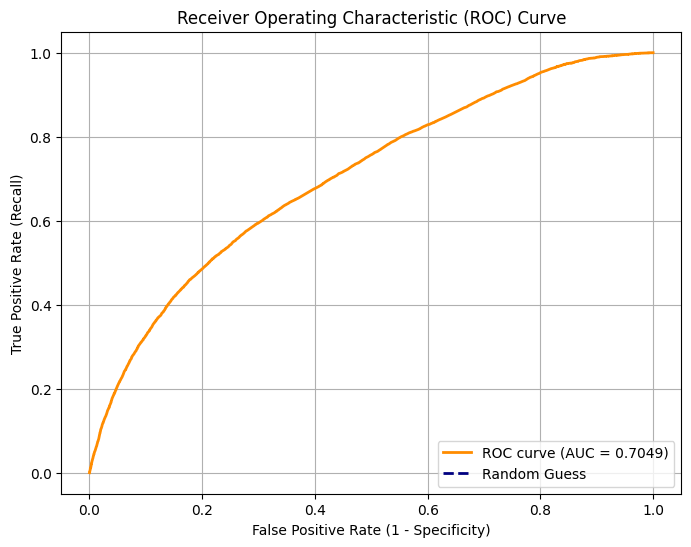

In [6]:
# ----------------------------------------------------
# 6. MAIN VISUALIZATION (ROC Curve - Example Advanced Visualization)
# ----------------------------------------------------

# Generate ROC Curve (Advanced Visualization Technique - Exercise 7)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([1], [1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
# NOTE: This plot will be copied into the final report as the Main Visualization.
